# Imports & Env. Config

In [1]:
!pip install mmcif_pdbx
!pip install pandas-profiling
!pip install pyarrow
!pip install biopython
!chmod 777 -R /home/jupyter/pss/blast

# mmCIF / Protein Libs
import pdbx
from pdbx.reader import PdbxReader
from pdbx.reader import DataContainer
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from Bio import SearchIO

# I/O Libs
from google.cloud import storage
import io
from io import StringIO
import os
from IPython.display import clear_output

# Data Manipulation Libs
import pandas as pd
import numpy as np
import math
import random
import gzip
import pyarrow as pa
import pyarrow.parquet as pq

# Viz Libs
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()

# ML Libs
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
from sklearn.datasets import make_blobs

os.environ['PATH'] = '/opt/conda/bin:/opt/conda/condabin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games:/home/jupyter/pss/blast/bin/:'

clear_output()

In [2]:
# Instantiates a client & loads credentials
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "PSS GCS Storage Key.json"
storage_client = storage.Client()

# Download List of Filenames (mmCIF) From GCS

In [68]:
path = 'UP000005640_9606_HUMAN/cif/'
filenames = []
blob_list = storage_client.get_bucket('capstone-fall21-protein').list_blobs()
for blob in blob_list:
    if path in blob.name:
        filenames.append(blob.name[27:].split('.')[0])
print(f'Indexed {len(filenames)} files.')

Indexed 23391 files.


# Control: BLAST Scores + e-Values for Randomly Clustered Proteins

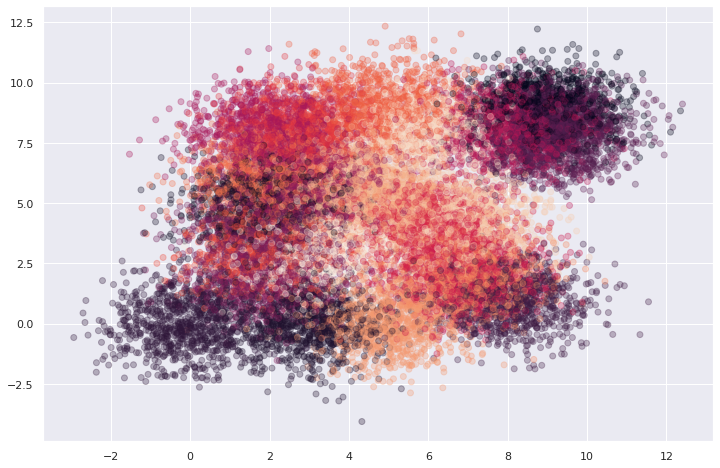

In [71]:
# create random clusters of len(filenames)

random_seed = 76523

random.seed(random_seed)
centers = [(random.randrange(0, 10), random.randrange(0, 10)) for i in range(25)]
X, y = make_blobs(n_samples=len(filenames), centers=centers, n_features=500, random_state=random_seed)
figure(figsize=(12,8))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3)
plt.show()

In [97]:
# extract cluster 1 intercepts + assign to first len(cluster_1) proteins in filenames

cluster_1 = X[y == 1]
cluster_1_examples = pd.DataFrame(cluster_1)
cluster_1_examples['protein'] = pd.DataFrame(filenames[:len(cluster_1_examples)])
cluster_1_examples.columns = ['X', 'Y', 'protein']
print(cluster_1_examples.sample(10))
print(len(cluster_1_examples))

            X         Y                    protein
198  0.756504  6.778080  AF-A0A0B4J2E0-F1-model_v1
628  1.208435  5.970264      AF-A1L162-F1-model_v1
131  1.281987  5.865629  AF-A0A0A0MT36-F1-model_v1
650  2.033076  7.044898      AF-A2A2V5-F1-model_v1
826  0.736807  4.535785      AF-A6NDL7-F1-model_v1
772  2.671062  4.447074      AF-A5PLL7-F1-model_v1
858  2.251879  5.133961      AF-A6NER0-F1-model_v1
911  1.618415  4.178265      AF-A6NGQ2-F1-model_v1
518  2.118912  4.338260  AF-A0A494C193-F1-model_v1
894  1.906910  6.148431      AF-A6NG13-F1-model_v1
936


In [98]:
def get_protein_sequence(selection=None):
    '''
    Given a list of proteins (full filenames), returns atoms' X, Y and Z coordinates
    along with protein name. If no selection is provided, returns all proteins' (23K)
    atoms.
    '''
    stats = [0, 0]
    result = []
    alias = 'tmp.cif.gz'
    
    if selection is None:
        selection = filenames

    for file in selection:
        data=[]
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(path + file + '.cif.gz')
        blob.download_to_filename(alias)

        with gzip.open(alias) as f:
            file_content = f.read()

        txt = io.StringIO(file_content.decode("utf-8"))

        stats[0] += 1
        pRd = PdbxReader(txt)
        pRd.read(data)
        txt.close()
        block = data[0]

        obj = block.get_object("struct_ref")

        for row in obj.get()[2]:
            result.append(row)

        stats[1] += len(obj.get()[2])
        os.remove(alias)

    print(f'Processed {stats[0]} proteins ({stats[1]} rows).')
    result = np.array(result)
    result = np.append(np.array(selection).reshape((len(result),1)), result[:,7].reshape((len(result),1)), axis=1) #result[:,5].reshape((len(result),1))
    return result

In [99]:
cluster_1_sequences = get_protein_sequence(cluster_1_examples['protein'].to_list())

Processed 936 proteins (936 rows).


In [101]:
# First we take all cluster sequences and write them to single fasta file
f = open("tmp.fasta", "w")
# doing this to make each entry unique bc there are "duplicate" protein names
# TODO: figure this out; see code block below
i = 0

for protein, sequence in cluster_1_sequences:
    sequence = sequence.replace('\n', '')
    
    f.write(f'>{protein}')
    
    for pos in range(len(sequence)):
        if pos % 60 == 0:
            f.write('\n')
        f.write(sequence[pos])

    i += 1
    f.write('\n')
    
f.close()
print(f'{len(cluster_1_sequences)} Protein sequences concatenated into tmp.fasta.')

936 Protein sequences concatenated into tmp.fasta.


In [102]:
# Next we turn the file into a BLAST database
!./blast/bin/makeblastdb -in tmp.fasta -parse_seqids -blastdb_version 5 -dbtype prot
print(f'BLAST db built with {len(cluster_1_sequences)} proteins as tmp.fasta.pdb and indices.')



Building a new DB, current time: 09/22/2021 23:10:26
New DB name:   /home/jupyter/pss/tmp.fasta
New DB title:  tmp.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/jupyter/pss/tmp.fasta
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 936 sequences in 0.025311 seconds.


BLAST db built with 936 proteins as tmp.fasta.pdb and indices.


In [103]:
# And then run blastp on the file, cross-joining on itself 
# (blast each protein in the file to each other protein in the file)
!./blast/bin/blastp -db tmp.fasta -query tmp.fasta -out results.out -outfmt 6
print(f'BLASTP complete. Results at results.out.')

BLASTP complete. Results at results.out.


In [104]:
from google.cloud.storage import Blob
# Next read in the results, format them and upload to GCS
parser = SearchIO.parse("results.out", "blast-tab")
num_queries = len(list(parser))
parser = SearchIO.parse("results.out", "blast-tab")

formatted_data = []

for queries in range(num_queries):
    result = next(parser)
    for hsp in result.hsps:
        # ignore self-matches
        if result.id != hsp.hit_id:
            formatted_data.append([result.id, hsp.hit_id, hsp.bitscore, hsp.evalue])
        
pd.DataFrame(formatted_data, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations.csv', index=False)
bucket = storage_client.get_bucket('capstone-fall21-protein')
blob = Blob("annotations/blast_annotations.csv", bucket)
with open('blast_annotations.csv', "rb") as my_file:
     blob.upload_from_file(my_file)

print(f'Structured BLAST results saved to GCS.')

Structured BLAST results saved to GCS.


**Plots for First Class Presentation**

In [105]:
m = pd.DataFrame(formatted_data, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).sort_values(['bitscore', 'evalue'], ascending=[False, True])

array([[<AxesSubplot:title={'center':'bitscore'}>]], dtype=object)

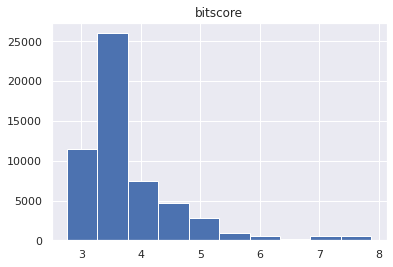

In [106]:
m[['bitscore']].apply(np.log).hist()

array([[<AxesSubplot:title={'center':'evalue'}>]], dtype=object)

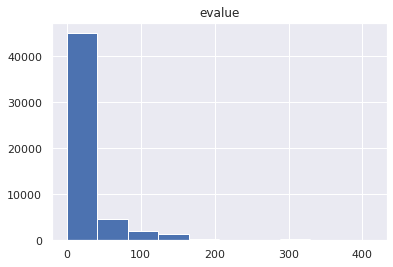

In [107]:
m[['evalue']][m.evalue > 0].apply(np.log).apply(np.abs).hist()

**Re-Implementation TODOs:**
* Wrap BLAST pipeline in function
* First check if input pairs have already been BLASTed in annotations csv
* If so, return pre-computed scores
* If not, run BLAST pipeline, append to annotations csv
* Return results

**Test BLAST Parameters on Small Query (Target)**

In [263]:
# -outfmt 6 means tab-delimited; corresponding param for SearchIO.parse is "blast-tab"
!./blast/bin/blastp -db tmp.fasta -query tmp_test.fasta -out results_test.out -outfmt 6

In [264]:
parser = SearchIO.parse("results_test.out", "blast-tab")
num_queries = len(list(parser))
parser = SearchIO.parse("results_test.out", "blast-tab")

formatted_data = []

for queries in range(num_queries):
    result = next(parser)
    for hsp in result.hsps:
        formatted_data.append([result.id, hsp.hit_id, hsp.bitscore, hsp.evalue])

In [265]:
pd.DataFrame(formatted_data, columns=['query_protein', 'target_protein', 'bitscore', 'evalue']).to_csv('blast_annotations_test.csv', index=False)
bucket = storage_client.get_bucket('capstone-fall21-protein')
my_file.upload_from_file(open('blast_annotations_test.csv'))

# Scratch

## BLAST Example

In [107]:
# First download and unpack BLAST+ (linux x86) at /home/jupyter/pss/blast/
# Make sure /home/jupyter/pss/blast/bin/* has been chmod 777'd

# Create two sequence files
seq1 = SeqRecord(Seq(cluster_1_sequences[0][1]), id=cluster_1_sequences[0][0])
seq2 = SeqRecord(Seq(cluster_1_sequences[1][1]), id=cluster_1_sequences[1][0])
SeqIO.write(seq1, "seq1.fasta", "fasta")
SeqIO.write(seq2, "seq2.fasta", "fasta")

# Run BLAST and parse the output as XML
output = NcbiblastpCommandline(query="seq1.fasta", subject="seq2.fasta", outfmt=5)()[0]
blast_result_record = NCBIXML.read(StringIO(output))

# The BLAST E-value is the number of expected hits of similar quality (score)
# that could be found just by chance. E-value of 10 means that up to 10 hits can
# be expected to be found just by chance, given the same size of a random
# database. The lower the E-value, or the closer it is to zero, the more 
# "significant" the match is.

# The bit score, S', is derived from the raw alignment score, S, taking the
# statistical properties of the scoring system into account. Because bit scores 
# are normalized with respect to the scoring system, they can be used to compare
# alignment scores from different searches. Higher is better, but after 50 there
# is little added statistical benefit.

for alignment in blast_result_record.alignments:
    for hsp in alignment.hsps:
        print('****Alignment****')
        print('sequence:', alignment.title)
        print('length:', alignment.length)
        print('e value:', hsp.expect)
        print('score:', hsp.score)
        #print(hsp.query)
        #print(hsp.match)
        #print(hsp.sbjct)

****Alignment****
sequence: A0A024RBG1 A0A024RBG1 <unknown description>
length: 181
e value: 1.19342
score: 21.0


## Atom Cartesian Coordinate Clustering (see [`protein_eda`](protein_eda.ipynb) Notebook)

In [89]:
X = atoms[['_atom_site.Cartn_x', '_atom_site.Cartn_y', '_atom_site.Cartn_z']].copy(deep=True)
X.to_numpy()
X = preprocessing.StandardScaler().fit(X).transform(X)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
y_kmeans = kmeans.predict(X)

figure(figsize=(14,10))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=5, cmap='summer', alpha=0.3)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## How to Write Parquet Files

In [177]:
table = pa.Table.from_pandas(pd.DataFrame(r[:5]))
pq.write_table(table, 'repr_random.parquet')

## Proof of Concept for Randomly Sampling Proteins, Unzipping & Processing

In [ ]:
data=[]
stats = [0, 0]
result = []
alias = 'tmp.cif.gz'

for file in random.sample(filenames, 10):
    blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
    blob.download_to_filename(alias)

    with gzip.open(alias) as f:
        file_content = f.read()

    txt = io.StringIO(file_content.decode("utf-8"))

    stats[0] += 1
    pRd = PdbxReader(txt)
    pRd.read(data)
    txt.close()
    block = data[0]

    obj = block.get_object("atom_site")

    for row in obj.get()[2]:
        result.append(row)

    stats[1] += len(obj.get()[2])

os.remove(alias)
print(f'Processed {stats[0]} proteins ({stats[1]} rows).')

In [ ]:
atoms = pd.DataFrame(data=result, columns=obj.item_name_list, dtype=float)
atoms.sample(10)

## Get Atoms

In [6]:
def get_atoms(selection=None):
    '''
    Given a list of proteins (full filenames), returns atoms' X, Y and Z coordinates
    along with protein name. If no selection is provided, returns all proteins' (23K)
    atoms.
    '''
    stats = [0, 0]
    result = []
    alias = 'tmp.cif.gz'
    
    if selection is None:
        selection = filenames
    
    for file in selection:
        data = []
        blob = storage_client.get_bucket('capstone-fall21-protein').get_blob(file)
        blob.download_to_filename(alias)

        with gzip.open(alias) as f:
            file_content = f.read()

        txt = io.StringIO(file_content.decode("utf-8"))

        stats[0] += 1
        pRd = PdbxReader(txt)
        pRd.read(data)
        txt.close()

        block = data[0]
        obj = block.get_object("atom_site")

        for row in obj.get()[2]:
            result.append(row)

        stats[1] += len(obj.get()[2])
        os.remove(alias)
    
    print(f'Processed {stats[0]} proteins ({stats[1]} rows).')
    result = np.array(result)
    result = np.column_stack((result[:,10:13], result[:,21]))
    return result

In [ ]:
cluster_1_atoms = get_atoms(cluster_1_examples['protein'].to_list())
pd.DataFrame(cluster_1_atoms, columns=['X', 'Y', 'Z', 'protein'])

## Misc.

In [ ]:
# NOT USED CURRENTLY
# extract protein names from filenames and generate 500 len random vector for each

#r = []
#for f in filenames:
#    r.append([f[30:].split("-", 1)[0], [random.random() for n in range(500)]])
#r = np.array(r)
#X = np.stack(r[:,1], axis=0)